<a href="https://colab.research.google.com/github/supuni9622/Test-Google-Colab/blob/main/Music_Classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
cd /content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV1-Music

/content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV1-Music


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix 
import seaborn as sns
from sklearn.metrics import classification_report

Import Data set

In [156]:
df = pd.read_csv('Music_DS.csv',encoding='cp1252')
df = df.dropna(how="any").reset_index(drop=True)
df.drop('Song_ID',
  axis='columns', inplace=True)
df.drop('Key',
  axis='columns', inplace=True)
df.head()

,Genre,Acorsticness,Tempo (bpm),Loudness (db),Energy,Danceability,Valence,Key-Name,Emotion
0,Pop,0.06,172,-4,0.87,0.55,0.76,D major,Inspiration
1,Pop,0.10,92,-6,0.71,0.54,0.29,G major,Sad
2,Pop,0.06,115,-7,0.66,0.74,0.34,C major,Inspiration
3,Pop,0.04,117,-5,0.89,0.62,0.82,A major,Inspiration
4,Pop,0.11,158,-6,0.84,0.63,0.79,B minor,Inspiration


# **Explore Data**

In [ ]:
print(df.shape)
print("Number of rows: "+str(df.shape[0]))
print("Number of columns: "+str(df.shape[1]))

(800, 9)
Number of rows: 800
Number of columns: 9


In [ ]:
df.columns

Index(['Genre', 'Acorsticness', 'Tempo (bpm)', 'Loudness (db)', 'Energy',
       'Danceability', 'Valence', 'Key-Name', 'Emotion'],
      dtype='object')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Acorsticness,800.0,0.297712,0.313664,0.00,0.03,0.16,0.54,1.00
Tempo (bpm),800.0,120.602500,29.216502,59.00,99.00,120.00,140.00,206.00
Loudness (db),800.0,-7.856250,4.044878,-44.00,-10.00,-7.00,-5.00,-1.00
Energy,800.0,0.596875,0.234357,0.00,0.43,0.63,0.79,1.00
Danceability,800.0,0.561700,0.166959,0.09,0.44,0.57,0.68,0.96
Valence,800.0,0.415038,0.241086,0.03,0.22,0.38,0.59,0.99


# **Visualize Data**

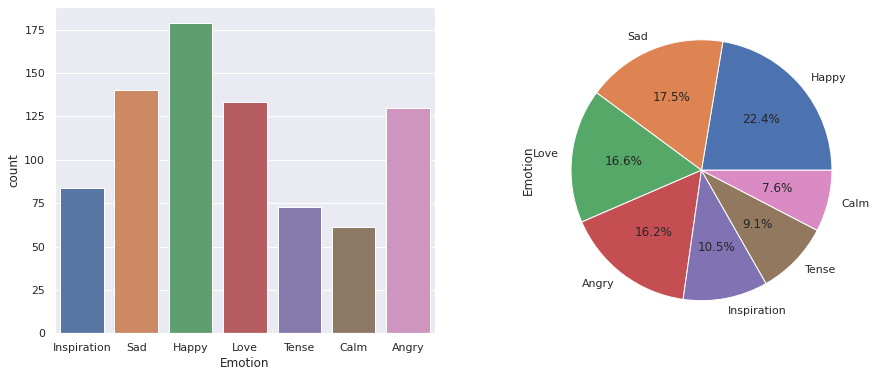

In [ ]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='Emotion', data=df, ax=ax[0])
_ = df['Emotion'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

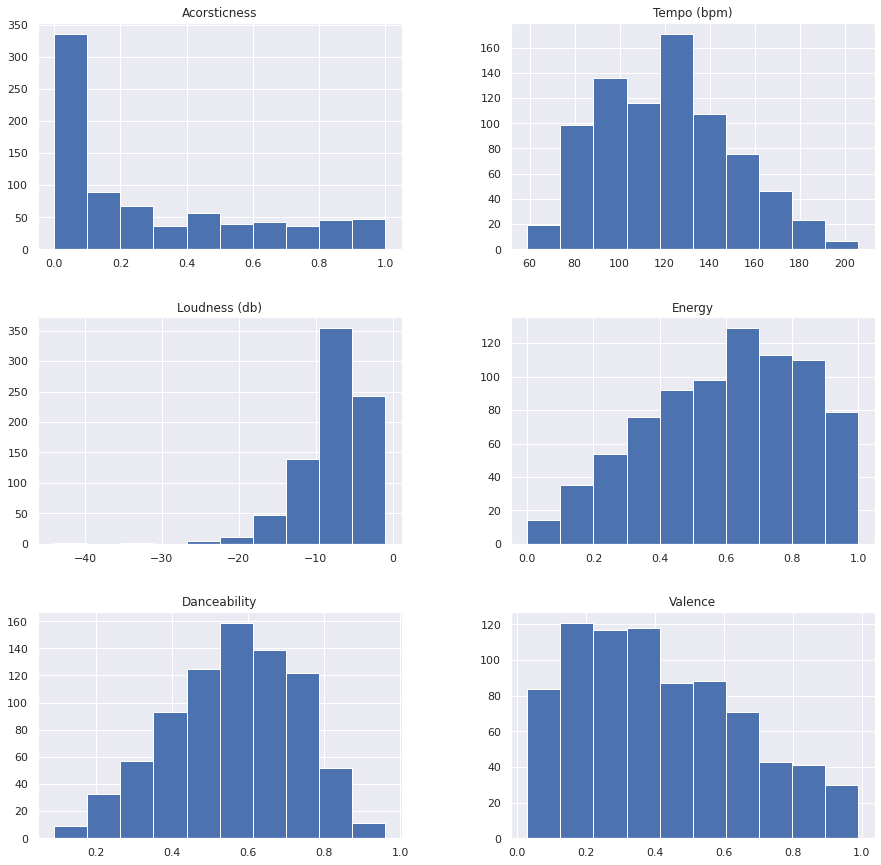

In [ ]:
df.hist(figsize=(15,15))
plt.show()

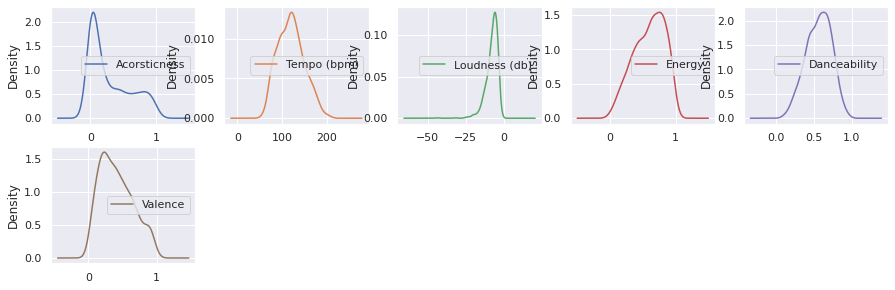

In [ ]:
df.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15))
plt.show()

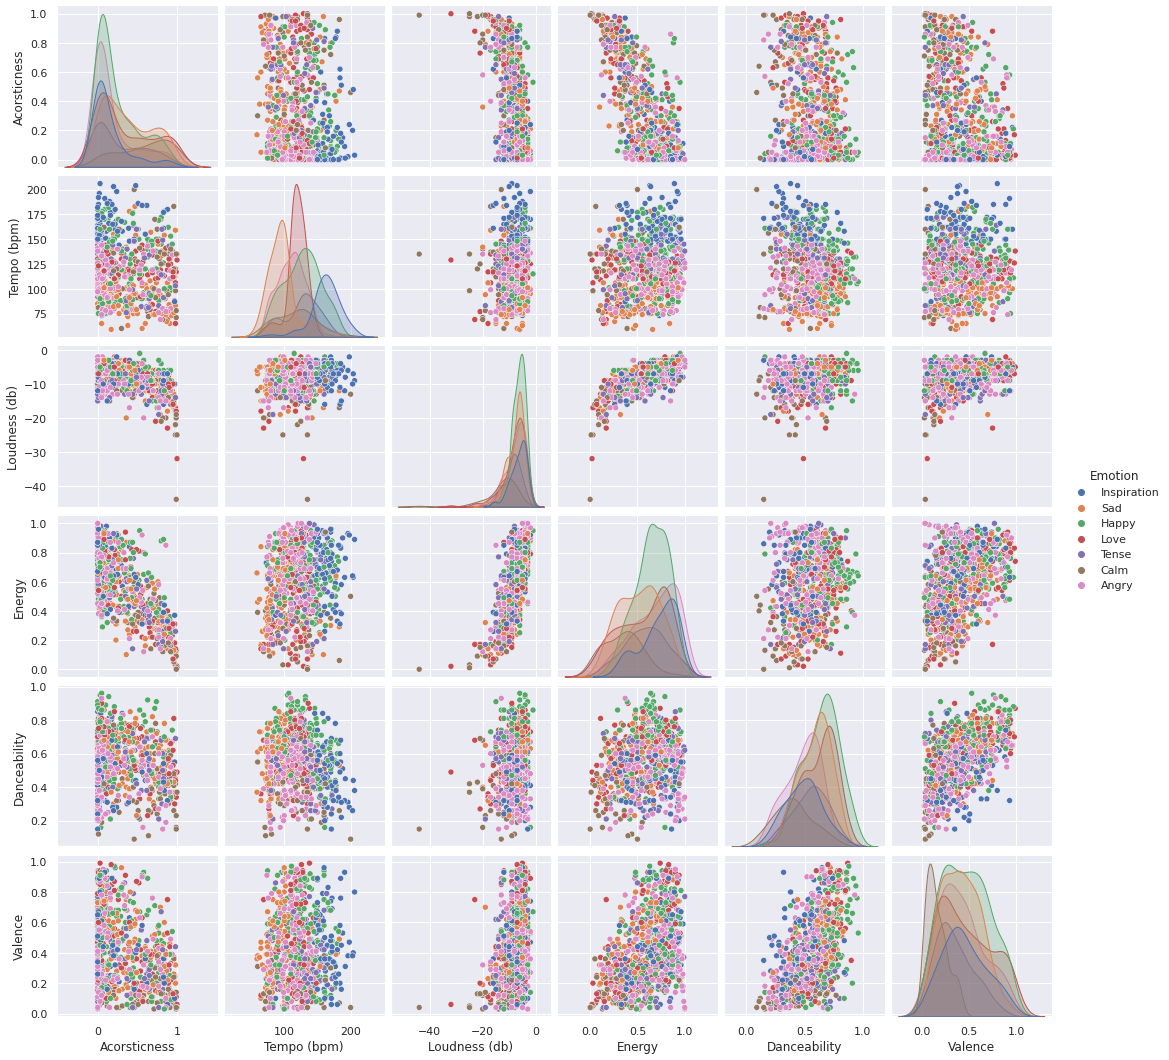

In [ ]:
sns.set()
sns.pairplot(df[['Genre', 'Acorsticness', 'Tempo (bpm)', 'Loudness (db)', 'Energy', 'Danceability', 'Valence', 'Key-Name','Emotion' ]],
            hue="Emotion", diag_kind="kde")
# sns.pairplot(df[['Genre', 'Tempo (bpm)', 'Loudness (db)','Emotion' ]],
            #  hue="Emotion", diag_kind="kde")

# **Data Preprocessing**

In [157]:
df.isnull().sum()

Genre            0
Acorsticness     0
Tempo (bpm)      0
Loudness (db)    0
Energy           0
Danceability     0
Valence          0
Key-Name         0
Emotion          0
dtype: int64

In [158]:
possible_labels = df.Genre.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Ambient': 10,
 'Blues': 11,
 'Classical': 9,
 'Country': 1,
 'Disco': 6,
 'EDM': 3,
 'Hip hop': 4,
 'Jazz': 5,
 'Metal': 7,
 'Pop': 0,
 'Rock': 2,
 'Techno': 8}

In [159]:
df['Genre'] = df.Genre.replace(label_dict)

In [160]:
possible_labelsKeys = df["Key-Name"].unique()

label_dictKeys = {}
for index, possible_label in enumerate(possible_labelsKeys):
    label_dictKeys[possible_label] = index
label_dictKeys

{'A major': 3,
 'A minor': 14,
 'A# major': 11,
 'A# minor': 24,
 'B major': 23,
 'B minor': 4,
 'C major': 2,
 'C minor': 17,
 'C# Minor': 6,
 'C# major': 5,
 'C# minor': 9,
 'D major': 0,
 'D minor': 18,
 'D# major': 10,
 'D# minor': 22,
 'E major': 12,
 'E minor': 13,
 'F major': 21,
 'F minor': 19,
 'F# major': 8,
 'F# minor': 15,
 'G major': 1,
 'G minor': 20,
 'G# major': 7,
 'G# minor': 16}

In [161]:
df['Key-Name'] = df["Key-Name"].replace(label_dictKeys)

In [162]:
df.head()

,Genre,Acorsticness,Tempo (bpm),Loudness (db),Energy,Danceability,Valence,Key-Name,Emotion
0,0,0.06,172,-4,0.87,0.55,0.76,0,Inspiration
1,0,0.10,92,-6,0.71,0.54,0.29,1,Sad
2,0,0.06,115,-7,0.66,0.74,0.34,2,Inspiration
3,0,0.04,117,-5,0.89,0.62,0.82,3,Inspiration
4,0,0.11,158,-6,0.84,0.63,0.79,4,Inspiration


In [163]:
X = df.iloc[:, 0:8].values
Y = df.iloc[:, -1].values

In [164]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(Y)

In [165]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder="passthrough")
X = np.array(X)

**Train & Test Data spilt**

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [167]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_predNB = gnb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predNB)
print(cm)
accuracy_score(y_test, y_predNB)

[[ 5  1  7  0  5  2  2]
 [ 0 13  0  0  0  1  0]
 [ 2  0 25  6  5  1  3]
 [ 1  0  3 10  0  0  1]
 [ 1  1 15  0  6  1  1]
 [ 0  4 10  0  0 11  4]
 [ 1  1  0  4  2  1  4]]


0.4625

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.50      0.23      0.31        22
           1       0.65      0.93      0.76        14
           2       0.42      0.60      0.49        42
           3       0.50      0.67      0.57        15
           4       0.33      0.24      0.28        25
           5       0.65      0.38      0.48        29
           6       0.27      0.31      0.29        13

    accuracy                           0.46       160
   macro avg       0.47      0.48      0.45       160
weighted avg       0.47      0.46      0.45       160



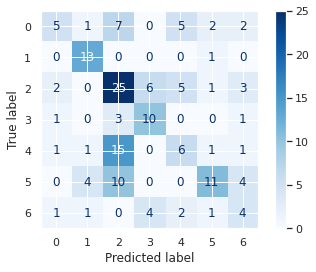

In [ ]:
plot_confusion_matrix(gnb,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predNB)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = gnb, X = X_train, y = y_train, cv = 6)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 46.72 %
Standard Deviation: 3.25 %


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score


acc1 = accuracy_score(y_test,y_pred)
acc1

0.475

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.52      0.55      0.53        22
           1       0.60      0.86      0.71        14
           2       0.49      0.52      0.51        42
           3       0.40      0.53      0.46        15
           4       0.38      0.40      0.39        25
           5       0.48      0.34      0.40        29
           6       0.40      0.15      0.22        13

    accuracy                           0.48       160
   macro avg       0.47      0.48      0.46       160
weighted avg       0.47      0.47      0.46       160



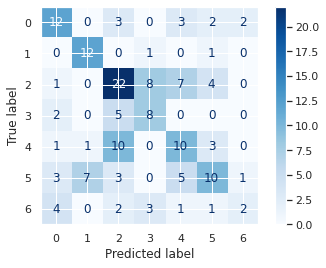

In [ ]:
plot_confusion_matrix(logreg,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_pred)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = logreg, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 47.66 %
Standard Deviation: 4.15 %


# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

y_predDT = dt.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predDT)
print(cm)
accuracy_score(y_test, y_predDT)

[[22  0  0  0  0  0  0]
 [ 0 13  1  0  0  0  0]
 [ 0  0 35  3  3  1  0]
 [ 2  0  1 12  0  0  0]
 [ 0  1  4  2 18  0  0]
 [ 0  0  1  0  4 24  0]
 [ 0  0  0  0  0  0 13]]


0.85625

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.93      0.93      0.93        14
           2       0.83      0.83      0.83        42
           3       0.71      0.80      0.75        15
           4       0.72      0.72      0.72        25
           5       0.96      0.83      0.89        29
           6       1.00      1.00      1.00        13

    accuracy                           0.86       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.86      0.86      0.86       160



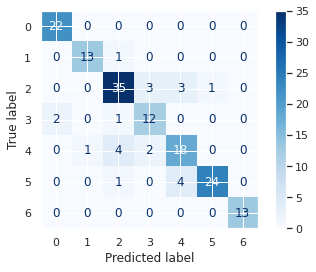

In [ ]:
plot_confusion_matrix(dt,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predDT)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 86.09 %
Standard Deviation: 3.59 %


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'criterion' : ['entropy','gini'], 'splitter' : ['best','random']}]
grid_search = GridSearchCV(estimator = dt,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 87.03 %
Best Parameters: {'criterion': 'entropy', 'splitter': 'best'}


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', random_state = 0)
classifierRF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=0)

In [ ]:
y_predRF = classifierRF.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predRF)
print(cm)
accuracy_score(y_test, y_predRF)

[[21  0  1  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0 30  6  6  0  0]
 [ 2  0  2 11  0  0  0]
 [ 1  1  3  0 20  0  0]
 [ 0  3  2  0  0 23  1]
 [ 0  1  0  2  0  0 10]]


0.80625

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.74      1.00      0.85        14
           2       0.79      0.71      0.75        42
           3       0.58      0.73      0.65        15
           4       0.77      0.80      0.78        25
           5       1.00      0.79      0.88        29
           6       0.91      0.77      0.83        13

    accuracy                           0.81       160
   macro avg       0.81      0.82      0.81       160
weighted avg       0.82      0.81      0.81       160



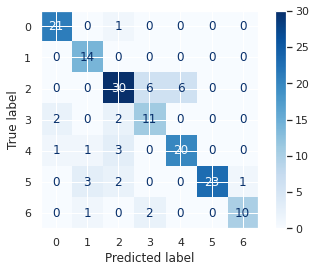

In [ ]:
plot_confusion_matrix(classifierRF,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predRF)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierRF, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 82.97 %
Standard Deviation: 4.96 %


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'criterion' : ['entropy','gini'], 'n_estimators' : [10,50,80,100,200,250,300,500,1000]}]
grid_search = GridSearchCV(estimator = classifierRF,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 84.69 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 300}


# **K- Nearest Naighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clfKNN = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clfKNN.fit(X_train,y_train)
y_predKNN = clfKNN.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predKNN)
print(cm)
accuracy_score(y_test, y_predKNN)

[[14  0  3  0  2  1  2]
 [ 0 10  0  0  1  2  1]
 [11  0 23  6  0  1  1]
 [ 2  0  5  7  0  1  0]
 [ 3  0  5  0 12  4  1]
 [ 3  2  2  0  1 18  3]
 [ 3  1  3  0  1  0  5]]


0.55625

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.39      0.64      0.48        22
           1       0.77      0.71      0.74        14
           2       0.56      0.55      0.55        42
           3       0.54      0.47      0.50        15
           4       0.71      0.48      0.57        25
           5       0.67      0.62      0.64        29
           6       0.38      0.38      0.38        13

    accuracy                           0.56       160
   macro avg       0.57      0.55      0.55       160
weighted avg       0.58      0.56      0.56       160



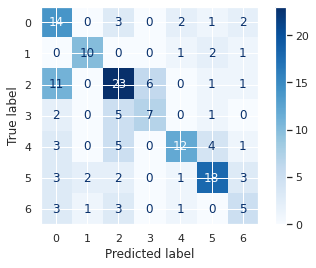

In [ ]:
plot_confusion_matrix(clfKNN,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predKNN)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clfKNN, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 55.78 %
Standard Deviation: 5.76 %


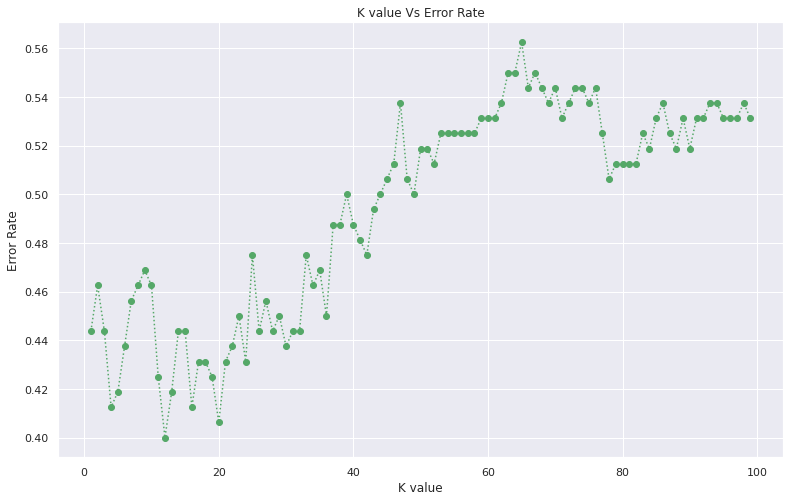

In [ ]:
error_rate=[]
for i in range(1,100):
             knn = KNeighborsClassifier(n_neighbors=i)
             model = knn.fit(X_train,y_train)
             pred_i = knn.predict(X_test)
             error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(13,8))
plt.plot(range(1,100), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K value')
plt.ylabel('Error Rate')
plt.title('K value Vs Error Rate')
plt.show() 

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_neighbors' : [2,3,4,5,6,7,8,9,10],'weights' : ['uniform', 'distance'], 'algorithm': ['auto', 'brute'],'metric' : ['minkowski'], 'p' : [2,3,4,5,6,7,8,9,10]},
              {'n_neighbors' : [2,3,4,5,6,7,8,9,10],'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size':[20,30,40,50,60,70,80,90,100],'metric' : ['minkowski'], 'p' : [2,3,4,5,6,7,8,9,10]},
              {'n_neighbors' : [2,3,4,5,6,7,8,9,10], 'metric' : ['euclidean']},
              {'n_neighbors' : [2,3,4,5,6,7,8,9,10], 'metric' : ['manhattan']},
              {'n_neighbors' : [2,3,4,5,6,7,8,9,10], 'metric' : ['chebyshev']}
              ]
grid_search = GridSearchCV(estimator = clfKNN,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 66.72 %
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10}


# **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

classifierSVM = SVC(C=10,kernel = 'rbf', gamma=0.1 )
classifierSVM.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [ ]:
y_predSVM = classifierSVM.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predSVM)
print(cm)
accuracy_score(y_test, y_predSVM)

[[16  0  5  0  0  0  1]
 [ 0 14  0  0  0  0  0]
 [ 6  0 28  4  3  0  1]
 [ 1  0  4 10  0  0  0]
 [ 2  1  2  0 19  1  0]
 [ 0  3  2  0  0 24  0]
 [ 2  1  4  1  0  0  5]]


0.725

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.59      0.73      0.65        22
           1       0.74      1.00      0.85        14
           2       0.62      0.67      0.64        42
           3       0.67      0.67      0.67        15
           4       0.86      0.76      0.81        25
           5       0.96      0.83      0.89        29
           6       0.71      0.38      0.50        13

    accuracy                           0.73       160
   macro avg       0.74      0.72      0.72       160
weighted avg       0.74      0.72      0.72       160



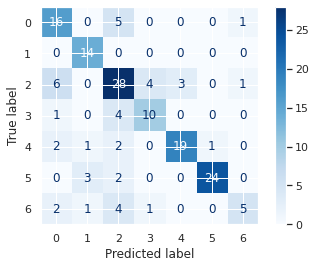

In [ ]:
plot_confusion_matrix(classifierSVM,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predSVM)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierSVM, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 69.53 %
Standard Deviation: 6.10 %


In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(X_train,y_train)
y_pred4 = svc1.predict(X_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
print(acc4)

rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
acc5 = accuracy_score(y_test,poly_pred)
acc6 = accuracy_score(y_test,rbf_pred)
print(acc5)
print(acc6)


0.55
0.5625
0.28125


In [ ]:
from sklearn.metrics import f1_score

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  56.25
F1 (Polynomial Kernel):  54.02


In [ ]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  28.12
F1 (RBF Kernel):  14.48


Applying Grid Search to find the best model and the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1,2,3,5]},
              {'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['poly'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1,2,3,5]}]
grid_search = GridSearchCV(estimator = classifierSVM,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 6,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 65.77 %
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


# **XGBoost**

In [ ]:
from xgboost import XGBClassifier
classifierXGB = XGBClassifier()
classifierXGB.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
y_predXGB = classifierXGB.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predXGB)
print(cm)
accuracy_score(y_test, y_predXGB)

[[22  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0 41  1  0  0  0]
 [ 2  0  0 13  0  0  0]
 [ 0  1  4  0 20  0  0]
 [ 0  1  2  0  0 26  0]
 [ 0  0  0  0  0  0 13]]


0.93125

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.88      1.00      0.93        14
           2       0.87      0.98      0.92        42
           3       0.93      0.87      0.90        15
           4       1.00      0.80      0.89        25
           5       1.00      0.90      0.95        29
           6       1.00      1.00      1.00        13

    accuracy                           0.93       160
   macro avg       0.94      0.93      0.93       160
weighted avg       0.94      0.93      0.93       160



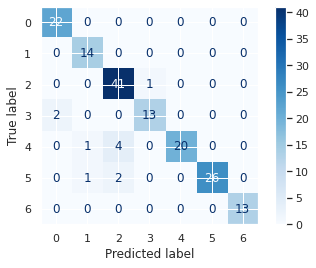

In [ ]:
plot_confusion_matrix(classifierXGB,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predXGB)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierXGB, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 89.22 %
Standard Deviation: 4.10 %


# **Ensemble Methods**

**Bagging Meta Estimater**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
classifierBAG = BaggingClassifier(KNeighborsClassifier(),max_samples=0.6, max_features=0.2)
classifierBAG.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.2,
                  max_samples=0.6)

In [ ]:
y_predBAG = classifierBAG.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predBAG)
print(cm)
accuracy_score(y_test, y_predBAG)

[[17  0  5  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0 26  0  1 15  0]
 [ 9  0  3  0  1  2  0]
 [ 1  2  6  0  3 13  0]
 [ 0  2  4  0  1 22  0]
 [ 0  0  0  0  0  0 13]]


0.59375

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.78      1.00      0.88        14
           2       0.59      0.62      0.60        42
           3       0.00      0.00      0.00        15
           4       0.50      0.12      0.19        25
           5       0.42      0.76      0.54        29
           6       1.00      1.00      1.00        13

    accuracy                           0.59       160
   macro avg       0.56      0.61      0.56       160
weighted avg       0.55      0.59      0.54       160



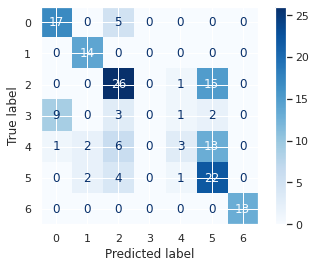

In [ ]:
plot_confusion_matrix(classifierBAG,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predBAG)) 

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierBAG, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 59.06 %
Standard Deviation: 9.63 %


**Extremely Randomized Trees**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

clfEDT = DecisionTreeClassifier(max_depth=10, min_samples_split=2,random_state=10)
scores = cross_val_score(clfEDT, X_train, y_train, cv=6)
scores.mean()

0.8530682419326397

In [ ]:

clfERF = RandomForestClassifier(n_estimators=60, max_depth=None,min_samples_split=2, random_state=10)
scores = cross_val_score(clfERF, X_train, y_train, cv=10)
scores.mean()

0.828125

In [ ]:
clfETC = ExtraTreesClassifier(n_estimators=40, max_depth=None,min_samples_split=6, random_state=10)
scores = cross_val_score(clfETC, X_train, y_train, cv=6)
scores.mean()

0.8516134720507846

**AdaBoost classifier with 100 weak learners**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clfAB = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clfAB, X_train, y_train, cv=10)
scores.mean()

0.39375

**Gradient Tree Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clfGTB = GradientBoostingClassifier(n_estimators=10, learning_rate=2.5,max_depth=None, random_state=42).fit(X_train, y_train)
scores = cross_val_score(clfGTB, X_train, y_train, cv=6)
scores.mean()

0.8593281608181979

**Voting Classifiers**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clfVLG = LogisticRegression(random_state=10)
clfVRF = RandomForestClassifier(n_estimators=50, random_state=10)
clfVNB = GaussianNB()

eclf1 = VotingClassifier(estimators=[('lr', clfVLG), ('rf', clfVRF), ('gnb', clfVNB)],voting='soft')

for clf, label in zip([clfVLG, clfVRF, clfVNB, eclf1], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.48 (+/- 0.04) [Logistic Regression]
Accuracy: 0.82 (+/- 0.05) [Random Forest]
Accuracy: 0.47 (+/- 0.06) [naive Bayes]
Accuracy: 0.66 (+/- 0.06) [Ensemble]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=8)
clf3 = SVC(kernel='rbf', probability=True)
eclf2 = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
eclf2 = eclf2.fit(X_train, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf2], ['DT', 'KNN', 'SVC', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=6)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.77 (+/- 0.02) [DT]
Accuracy: 0.54 (+/- 0.06) [KNN]
Accuracy: 0.64 (+/- 0.05) [SVC]
Accuracy: 0.83 (+/- 0.04) [Ensemble]


In [ ]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=10)
clf2 = RandomForestClassifier(random_state=10)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=10)
grid = grid.fit(X_train, y_train)
print("grid.best_score_", grid.best_score_)
grid.best_params_

grid.best_score_ 0.675


{'lr__C': 1.0, 'rf__n_estimators': 200}

# **MLP Classifier**

In [ ]:
from sklearn.neural_network import MLPClassifier

clfMLP = MLPClassifier(activation= 'tanh', alpha= 1e-05, hidden_layer_sizes= (500, 497), solver='adam', random_state=1)
clfMLP.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(500, 497),
              random_state=1)

In [ ]:
y_predMLP = clfMLP.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_predMLP)
print(cm)
accuracy_score(y_test, y_predMLP)

[[21  0  0  0  0  0  1]
 [ 0 13  0  0  0  0  1]
 [ 0  0 36  3  1  2  0]
 [ 3  0  2 10  0  0  0]
 [ 0  1  4  1 19  0  0]
 [ 0  4  2  0  0 23  0]
 [ 1  1  0  1  0  0 10]]


0.825

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.68      0.93      0.79        14
           2       0.82      0.86      0.84        42
           3       0.67      0.67      0.67        15
           4       0.95      0.76      0.84        25
           5       0.92      0.79      0.85        29
           6       0.83      0.77      0.80        13

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.81       160
weighted avg       0.84      0.82      0.83       160



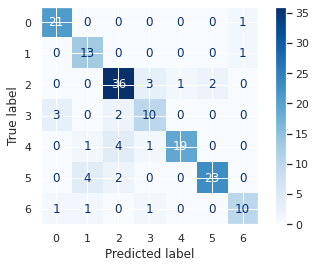

In [169]:
plot_confusion_matrix(clfMLP,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,y_predMLP)) 

In [168]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predMLP))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.68      0.93      0.79        14
           2       0.82      0.86      0.84        42
           3       0.67      0.67      0.67        15
           4       0.95      0.76      0.84        25
           5       0.92      0.79      0.85        29
           6       0.83      0.77      0.80        13

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.81       160
weighted avg       0.84      0.82      0.83       160



In [170]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clfMLP, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Accuracy: 82.34 %
Standard Deviation: 3.83 %


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [171]:
from sklearn.model_selection import GridSearchCV
parameters = [{'solver': ['lbfgs', 'sgd', 'adam'], 'alpha' : [1e-5, 1e-6, 1e-4],'hidden_layer_sizes':[(5, 2), (100, 97), (200,197), (500, 497)], 'activation' : ['identity', 'logistic', 'tanh', 'relu']},]
grid_search = GridSearchCV(estimator = clfMLP,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 82.34 %
Best Parameters: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (500, 497), 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# ANN

In [172]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [176]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

# ann = tf.keras.models.Sequential()
# ann.add(tf.keras.layers.Dense(units=2, activation='relu'))
# ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# ann.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# ann.fit(X_train, y_train, batch_size = 64, epochs = 10)

model = Sequential()
model.add(Dense(20, input_dim=8, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["accuracy"])
model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                180       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.fit(X_train, y_train, verbose=1, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: -11.4298 - accuracy: 0.0734
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: -12.6795 - accuracy: 0.0734
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: -14.0600 - accuracy: 0.0734
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: -15.5108 - accuracy: 0.0734
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: -17.0537 - accuracy: 0.0734
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: -18.7252 - accuracy: 0.0734
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: -20.4560 - accuracy: 0.0734
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: -22.3574 - accuracy: 0.0734
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: -24.3206 - accuracy: 0.0734
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: -26.4167 - accuracy: 0.0734

In [186]:
score = model.evaluate(X_test, y_test,
                       batch_size=64, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: -26.0576 - accuracy: 0.0875
